# NaturalProofs Sensitivity analyses

In [ ]:
# load core libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.calibration import calibration_curve

import ast

# select GPU if available, else CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using device:", DEVICE)

# load tokenizer for detector model
tokenizer_detector = AutoTokenizer.from_pretrained(
    "detector_baseline", trust_remote_code=True
)

/home/cpsc477_kl938/evaluation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [ ]:
def build_aligned_longform_from_naturalproofs(
    input_path: str = "LLM_generated_naturalproofs.csv",
) -> pd.DataFrame:
    """
    read CSV, parse IDs, rename cols, drop dupes,
    group by generated answers, expand to long form.
    """
    df = pd.read_csv(input_path, index_col=False)

    # convert ID field into tuple, extract doc_id
    def parse_id(x):
        if isinstance(x, str):
            tup = tuple(ast.literal_eval(x))
        else:
            tup = tuple(x) if isinstance(x, (list, tuple)) else (x,)
        return tup

    df["ID_parsed"] = df["ID"].apply(parse_id)
    df["doc_id"]    = df["ID_parsed"].apply(lambda t: t[0])

    # rename for clarity
    df = df.rename(columns={
        "Problem":      "prompt",
        "zeroshot":     "ans_base",
        "fewshot":      "ans_few",
        "fewshot2":     "ans_hard",
        "ground_truth": "ans_human"
    })

    # remove exact duplicate rows
    df = df.drop_duplicates(
        subset=["doc_id","prompt","ans_base","ans_few","ans_hard","ans_human"],
        keep="first"
    )

    # group to collect list of human answers
    grouped = (
        df
        .groupby(["doc_id","prompt","ans_base","ans_few","ans_hard"], dropna=False)
        .agg({"ans_human": list})
        .reset_index()
    )

    # expand into rows: 3 auto variants + each human answer
    rows = []
    for _, r in grouped.iterrows():
        doc, prompt = r["doc_id"], r["prompt"]
        rows.extend([
            {"doc_id": doc, "prompt": prompt, "variant": "baseline",            "text": r["ans_base"], 'label': 0},
            {"doc_id": doc, "prompt": prompt, "variant": "few_shot",            "text": r["ans_few"],  'label': 0},
            {"doc_id": doc, "prompt": prompt, "variant": "prompt_engineering", "text": r["ans_hard"], 'label': 0},
        ])
        for human_text in r["ans_human"]:
            rows.append({"doc_id": doc, "prompt": prompt, "variant": "human", "text": human_text, "label": 1})

    long_df = pd.DataFrame(rows)
    print(f"🎯 Expanded to {len(long_df)} rows ({len(grouped)} docs × variants)")
    return long_df

if __name__ == "__main__":
    df_long = build_aligned_longform_from_naturalproofs()
    df_long.to_csv("aligned_naturalproofs_longform.csv", index=False)

🎯 Expanded to 4432 rows (1099 docs × (3 generated + N human variants))


In [3]:
df_long = df_long.dropna(subset=["text"]).reset_index(drop=True)

test_dfp = df_long.copy()
#test_dfp.head(20)

In [4]:
test_dfp.head()

,doc_id,prompt,variant,text,label
0,123,Let $S$ and $T$ be [[Definition:Set|sets]]. \n...,baseline,1. $x \in S * T$ if and only if $x \in S$ or $...,0
1,123,Let $S$ and $T$ be [[Definition:Set|sets]]. \n...,few_shot,1. $S * T = (S \cup T) \setminus (S \cap T)$\n...,0
2,123,Let $S$ and $T$ be [[Definition:Set|sets]]. \n...,prompt_engineering,1. $S * T = (S \cup T) \setminus (S \cap T)$\n...,0
3,123,Let $S$ and $T$ be [[Definition:Set|sets]]. \n...,human,=== [[Equivalence of Definitions of Symmetric ...,1
4,140,:$\mathbb U * S = \map \complement S$ \n where...,baseline,"To prove the statement, we will use the defini...",0


In [5]:
len(test_dfp)

4431

In [ ]:
# load labeled test set (long form)
# test_dfp = pd.read_csv("results/test_dfp_longform_labeled.csv")
print(f"🔎 Loaded test_dfp with {len(test_dfp)} rows")

# load detector outputs: preds, probs, logits
data = np.load("naturalproofs_detector_inference.npz")
MODEL_ORDER = ["Baseline", "SFT-LoRA", "RL-Detector"]

# verify each expected array is present
for m in MODEL_ORDER:
    for suffix in ("preds", "probs", "logits"):
        key = f"{m}_{suffix}"
        if key not in data:
            raise KeyError(f"missing key: {key}")
        print(f" {key:20s} → {data[key].shape}")

# check that array lengths match number of test rows
L = len(test_dfp)
for m in MODEL_ORDER:
    if data[f"{m}_preds"].shape[0] != L:
        raise ValueError(f"length mismatch for {m}")

# build dicts for easy access
preds_dict  = {m: data[f"{m}_preds"]  for m in MODEL_ORDER}
probs_dict  = {m: data[f"{m}_probs"]  for m in MODEL_ORDER}
logits_dict = {m: data[f"{m}_logits"] for m in MODEL_ORDER}

print("✅ Everything loaded and aligned. Ready for analysis!")

🔎 Loaded test_dfp with 4431 rows
 Baseline_preds       → shape = (4431,)
 Baseline_probs       → shape = (4431,)
 Baseline_logits      → shape = (4431, 2)
 SFT‑LoRA_preds       → shape = (4431,)
 SFT‑LoRA_probs       → shape = (4431,)
 SFT‑LoRA_logits      → shape = (4431, 2)
 RL‑Detector_preds    → shape = (4431,)
 RL‑Detector_probs    → shape = (4431,)
 RL‑Detector_logits   → shape = (4431, 2)
✅ Everything loaded and aligned. Ready for analysis!


In [9]:
preds_dict

{'Baseline': array([1, 1, 1, ..., 1, 1, 1]),
 'SFT‑LoRA': array([1, 1, 1, ..., 0, 0, 1]),
 'RL‑Detector': array([0, 0, 1, ..., 0, 0, 0])}

In [20]:
probs_dict

{'Baseline': array([0.9376032 , 0.97273624, 0.9826157 , ..., 0.83859885, 0.68142974,
        0.5449469 ], dtype=float32),
 'SFT‑LoRA': array([0.7681303 , 0.50647545, 0.55568093, ..., 0.3234296 , 0.04370593,
        0.53302675], dtype=float32),
 'RL‑Detector': array([0.1164204 , 0.02599575, 0.5356878 , ..., 0.04070373, 0.00564437,
        0.31213087], dtype=float32)}

In [ ]:
import re
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sentence_transformers import SentenceTransformer

# assume test_dfp, preds_dict, probs_dict, MODEL_ORDER exist
df = test_dfp.copy()

# attach model predictions and probabilities to df
for m in MODEL_ORDER:
    df[f"pred_{m}"] = preds_dict[m]
    df[f"prob_{m}"] = probs_dict[m]

# quantile‐bin proof lengths into 5 groups
df["length"]    = df["text"].str.split().str.len()
df["length_bin"]= pd.qcut(df["length"], 5, labels=False)
ranges = df.groupby("length_bin")["length"].agg(["min","max"])
labels = {i: f"{int(r['min'])}–{int(r['max'])}" for i,r in ranges.iterrows()}
df["length_range"] = df["length_bin"].map(labels)

# compute accuracy per length bin
acc_len = {
    m: df.groupby("length_range").apply(
            lambda g: accuracy_score(g["label"], g[f"pred_{m}"])
        )
    for m in MODEL_ORDER
}
df_len = pd.DataFrame(acc_len)

# compute semantic similarity vs confidence
embedder = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")
human_ex = df.loc[df["variant"]=="human", "text"].iloc[0]

def sem_sim(txt):
    v1 = embedder.encode(txt)
    v2 = embedder.encode(human_ex)
    cos = np.dot(v1, v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))
    return (cos + 1) / 2

df["sim"]      = df["text"].map(sem_sim)
df["sim_bin"]  = pd.qcut(df["sim"], 5, labels=False)
sim_ranges     = df.groupby("sim_bin")["sim"].agg(["min","max"])
sim_labels     = {i: f"{r['min']:.2f}–{r['max']:.2f}" for i,r in sim_ranges.iterrows()}
df["sim_range"]= df["sim_bin"].map(sim_labels)

# compute mean human‐prob per similarity bin
mean_conf = {
    m: [
        df.loc[df["sim_range"]==lbl, f"prob_{m}"].mean()
        for lbl in sim_labels.values()
    ]
    for m in MODEL_ORDER
}
df_conf = pd.DataFrame(mean_conf, index=list(sim_labels.values()))

/tmp/ipykernel_2055928/4179972578.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  m: df.groupby("length_range").apply(
/tmp/ipykernel_2055928/4179972578.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  m: df.groupby("length_range").apply(
/tmp/ipykernel_2055928/4179972578.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future

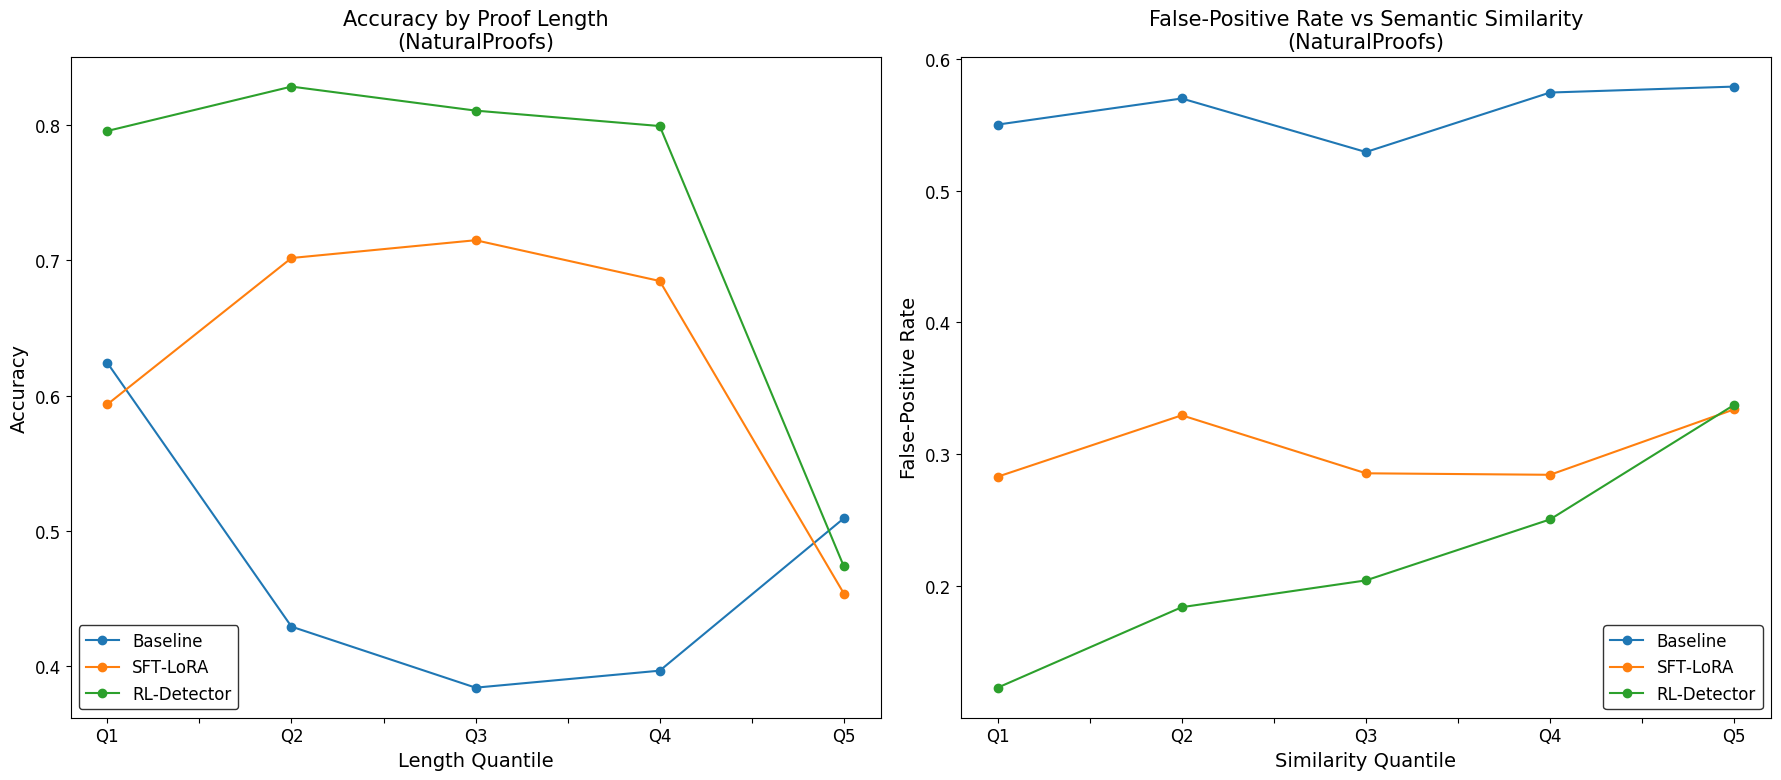

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# style settings
mpl.rcParams.update({
    "font.size":       13,
    "axes.titlesize":  15,
    "axes.labelsize":  14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize":18
})

# prepare false‐positive rates by sim quantile
sim_bins = sorted(df["sim_bin"].unique())
labels   = [f"Q{q+1}" for q in sim_bins]
fpr_by_q = {
    m: [(df.loc[df["sim_bin"]==q, f"pred_{m}"]==1).mean() for q in sim_bins]
    for m in MODEL_ORDER
}
fpr_df = pd.DataFrame(fpr_by_q, index=labels)

# plot length‐accuracy and FPR‐vs‐similarity side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# panel 1: accuracy by length quantile
acc_len_q = df_len.copy()
acc_len_q.index = [f"Q{i+1}" for i in range(len(acc_len_q))]
acc_len_q.plot(marker="o", ax=ax1)
ax1.set(
    title="Accuracy by Proof Length\n(NaturalProofs)",
    xlabel="Length Quantile",
    ylabel="Accuracy"
)
ax1.legend(MODEL_ORDER, loc="lower left", frameon=True, edgecolor="black")

# panel 2: false-positive rate by similarity quantile
fpr_df.plot(marker="o", ax=ax2)
ax2.set(
    title="False-Positive Rate vs Semantic Similarity\n(NaturalProofs)",
    xlabel="Similarity Quantile",
    ylabel="False-Positive Rate"
)
ax2.legend(MODEL_ORDER, loc="lower right", frameon=True, edgecolor="black")

plt.tight_layout()
fig.savefig("naturalproofs_three_panel_angles2.png", dpi=300, bbox_inches="tight")